# IMPORTING LIBRARIES

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

import pickle
import sklearn

# STEP 1: READ DATASET

In [2]:
df=pd.read_csv("Fraud_Analysis_Dataset.csv")

In [3]:
df_og=pd.read_csv("Fraud_Analysis_Dataset.csv")

In [4]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1
1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,1
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,1
4,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,1
5,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,1
6,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,1
7,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.00,1
8,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1
9,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.00,1


In [5]:
df.tail(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
11132,7,TRANSFER,731485.29,C751320808,0.00,0.00,C801142660,3504660.25,16400000.00,0
11133,7,TRANSFER,2943845.35,C1360289756,0.00,0.00,C1262822392,18000000.00,22600000.00,0
11134,7,TRANSFER,2861134.92,C1326904973,0.00,0.00,C991505714,5352935.74,14000000.00,0
11135,7,TRANSFER,80485.60,C1369223613,0.00,0.00,C465257140,1078685.56,1761413.49,0
11136,7,TRANSFER,19991.02,C1020193304,0.00,0.00,C1915624447,21586.00,17795.02,0
11137,7,DEBIT,6393.71,C1331144930,433084.38,426690.68,C684896216,478421.00,210535.25,0
11138,7,CASH_OUT,298799.54,C932023579,426690.68,127891.14,C1761353343,704355.36,5270364.19,0
11139,7,CASH_OUT,423159.63,C61395726,127891.14,0.00,C1298316171,610479.00,749621.53,0
11140,7,PAYMENT,1094.03,C1224570697,13918.00,12823.97,M983553548,0.00,0.00,0
11141,7,PAYMENT,9235.58,C1637966097,39963.00,30727.42,M609545864,0.00,0.00,0


In [6]:
df.shape

(11142, 10)

In [7]:
df.size

111420

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB


# STEP 2: DATA CLEANING

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [11]:
# Fraudulent transactions often involve merchants usually as receivers,
# so converting it into a numeric feature helps the model detect fraud patterns.

df["merchant_sender"]=df["nameOrig"].str.startswith("M").astype(int)
df["merchant_reciever"]=df["nameDest"].str.startswith("M").astype(int)


In [12]:
#Drop account ID columns because they are unique identifiers and 
# do not help the model learn any useful patterns

df=df.drop(['nameOrig','nameDest'],axis=1)

# STEP 3: DATA PREPROCESSING

In [13]:
# performing one hot encoding to convert categorical data into a numerical format that algorithms can process effectively

df= pd.get_dummies(df,columns=['type'],drop_first=True)

In [14]:
df.head(10)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,merchant_sender,merchant_reciever,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,181.00,181.00,0.0,0.0,0.00,1,0,0,False,False,False,True
1,1,181.00,181.00,0.0,21182.0,0.00,1,0,0,True,False,False,False
2,1,2806.00,2806.00,0.0,0.0,0.00,1,0,0,False,False,False,True
3,1,2806.00,2806.00,0.0,26202.0,0.00,1,0,0,True,False,False,False
4,1,20128.00,20128.00,0.0,0.0,0.00,1,0,0,False,False,False,True
5,1,20128.00,20128.00,0.0,6268.0,12145.85,1,0,0,True,False,False,False
6,1,416001.33,0.00,0.0,102.0,9291619.62,1,0,0,True,False,False,False
7,1,1277212.77,1277212.77,0.0,0.0,0.00,1,0,0,False,False,False,True
8,1,1277212.77,1277212.77,0.0,0.0,2444985.19,1,0,0,True,False,False,False
9,1,35063.63,35063.63,0.0,0.0,0.00,1,0,0,False,False,False,True


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   step               11142 non-null  int64  
 1   amount             11142 non-null  float64
 2   oldbalanceOrg      11142 non-null  float64
 3   newbalanceOrig     11142 non-null  float64
 4   oldbalanceDest     11142 non-null  float64
 5   newbalanceDest     11142 non-null  float64
 6   isFraud            11142 non-null  int64  
 7   merchant_sender    11142 non-null  int64  
 8   merchant_reciever  11142 non-null  int64  
 9   type_CASH_OUT      11142 non-null  bool   
 10  type_DEBIT         11142 non-null  bool   
 11  type_PAYMENT       11142 non-null  bool   
 12  type_TRANSFER      11142 non-null  bool   
dtypes: bool(4), float64(5), int64(4)
memory usage: 827.1 KB


# STEP 4: FEATURE ENGINEERING

In [16]:
# to calculate balance differences between origin and destination account

df['org_diff']  = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

In [17]:
# Flags cases where the sender or receiver balance do not change after the transaction
# In real transactions balances usually update if they don't it may indicate fraud

df['org_no_change']  = (df['oldbalanceOrg'] == df['newbalanceOrig']).astype(int)
df['dest_no_change'] = (df['oldbalanceDest'] == df['newbalanceDest']).astype(int)

In [18]:
# Create the ratio between transaction amount and origin balance
# Fraudsters often drain the entire account, leading to very high ratios.

df['amount_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)

In [19]:
# Convert step into meaningful hour and day features
# Each step represents one hour, extracting hourofday and dayofweek
# helps identify when fraud is more likely to occur.

df['hour'] = df['step'] % 24
df['day']  = df['step'] // 24

In [76]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,merchant_sender,merchant_reciever,type_CASH_OUT,...,type_TRANSFER,org_diff,dest_diff,org_no_change,dest_no_change,amount_ratio,hour,day,is_transfer,is_cashout
0,1,181.00,181.00,0.00,0.00,0.00,1,0,0,False,...,True,181.00,0.00,0,1,0.994505,1,0,False,False
1,1,181.00,181.00,0.00,21182.00,0.00,1,0,0,True,...,False,181.00,-21182.00,0,0,0.994505,1,0,False,False
2,1,2806.00,2806.00,0.00,0.00,0.00,1,0,0,False,...,True,2806.00,0.00,0,1,0.999644,1,0,False,False
3,1,2806.00,2806.00,0.00,26202.00,0.00,1,0,0,True,...,False,2806.00,-26202.00,0,0,0.999644,1,0,False,False
4,1,20128.00,20128.00,0.00,0.00,0.00,1,0,0,False,...,True,20128.00,0.00,0,1,0.999950,1,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11137,7,6393.71,433084.38,426690.68,478421.00,210535.25,0,0,0,False,...,False,6393.70,-267885.75,0,0,0.014763,7,0,False,False
11138,7,298799.54,426690.68,127891.14,704355.36,5270364.19,0,0,0,True,...,False,298799.54,4566008.83,0,0,0.700270,7,0,False,False
11139,7,423159.63,127891.14,0.00,610479.00,749621.53,0,0,0,True,...,False,127891.14,139142.53,0,0,3.308723,7,0,False,False
11140,7,1094.03,13918.00,12823.97,0.00,0.00,0,0,1,False,...,False,1094.03,0.00,0,1,0.078600,7,0,False,False


In [21]:
# Most fraud occurs during TRANSFER and CASH_OUT
# so explicitly marking these types helps the model learn fraud patterns.
# so creating binary flags

df['is_transfer'] = (type == 'TRANSFER')
df['is_cashout']  = (type == 'CASH_OUT')

In [22]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,merchant_sender,merchant_reciever,type_CASH_OUT,...,type_TRANSFER,org_diff,dest_diff,org_no_change,dest_no_change,amount_ratio,hour,day,is_transfer,is_cashout
0,1,181.00,181.00,0.00,0.00,0.00,1,0,0,False,...,True,181.00,0.00,0,1,0.994505,1,0,False,False
1,1,181.00,181.00,0.00,21182.00,0.00,1,0,0,True,...,False,181.00,-21182.00,0,0,0.994505,1,0,False,False
2,1,2806.00,2806.00,0.00,0.00,0.00,1,0,0,False,...,True,2806.00,0.00,0,1,0.999644,1,0,False,False
3,1,2806.00,2806.00,0.00,26202.00,0.00,1,0,0,True,...,False,2806.00,-26202.00,0,0,0.999644,1,0,False,False
4,1,20128.00,20128.00,0.00,0.00,0.00,1,0,0,False,...,True,20128.00,0.00,0,1,0.999950,1,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11137,7,6393.71,433084.38,426690.68,478421.00,210535.25,0,0,0,False,...,False,6393.70,-267885.75,0,0,0.014763,7,0,False,False
11138,7,298799.54,426690.68,127891.14,704355.36,5270364.19,0,0,0,True,...,False,298799.54,4566008.83,0,0,0.700270,7,0,False,False
11139,7,423159.63,127891.14,0.00,610479.00,749621.53,0,0,0,True,...,False,127891.14,139142.53,0,0,3.308723,7,0,False,False
11140,7,1094.03,13918.00,12823.97,0.00,0.00,0,0,1,False,...,False,1094.03,0.00,0,1,0.078600,7,0,False,False


In [23]:
df.size

245124

In [24]:
df.shape

(11142, 22)

# STEP 5: EDA

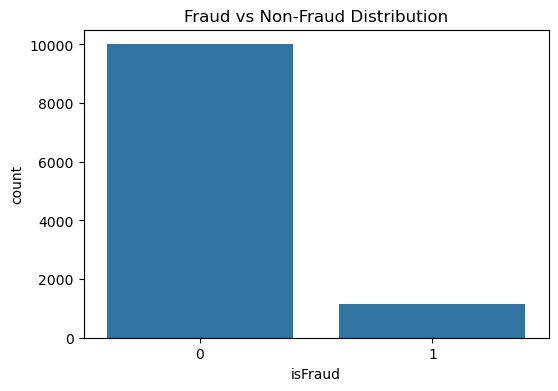

In [25]:
# FRAUD VS NON FRAUD DISTRIBUTION
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df_og, x='isFraud')
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

We visualized the fraud distribution to understand the class imbalance in the dataset

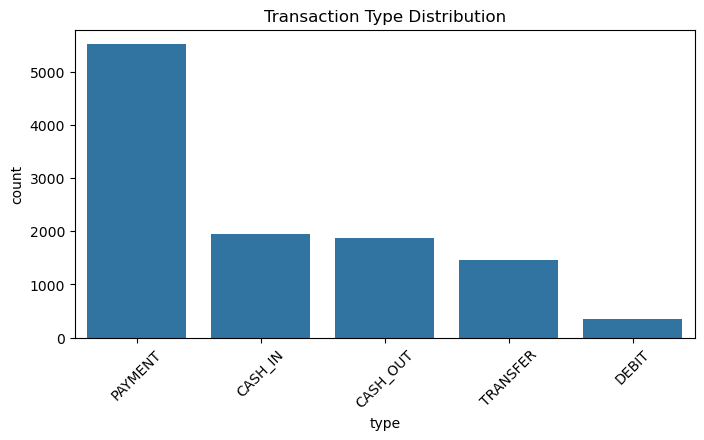

In [26]:
# TRANSACTION TYPE DISTRIBUTION
plt.figure(figsize=(8,4))
sns.countplot(data=df_og, x='type', order=df_og['type'].value_counts().index)
plt.title("Transaction Type Distribution")
plt.xticks(rotation=45)
plt.show()

Payment is the most frequent transaction type which states platform is heavily used to pay merchants
Fraud is concentrated in a small subset of transaction types-(Transfer and Cash_out)

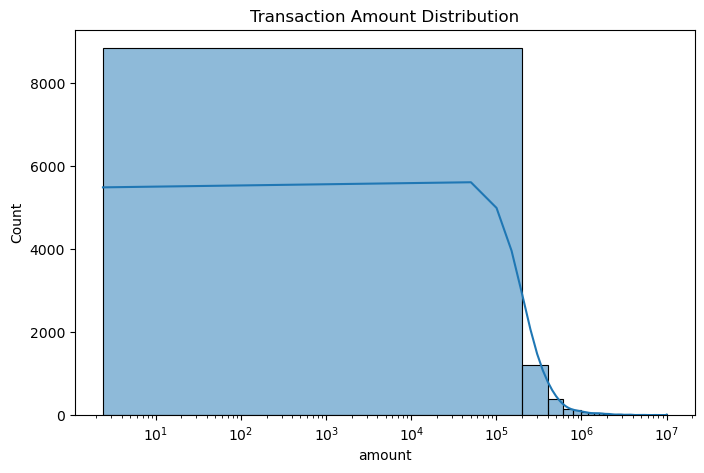

In [27]:
# TRANSACTION AMOUNT DISTRIBUTION
plt.figure(figsize=(8,5))
sns.histplot(df_og['amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xscale('log')   # recommended because amounts are skewed
plt.show()


The distribution of transaction amount is highly right-skewed, with most of the transactions low value and only a few being 
 very large. Using the log scale reveals this pattern clearly. Understanding this skew is important because fraudsters tend 
  to target higher-value transactions; thus, high-value outliers may seriously influence model training.
This visualization helps detect outliers before modeling.

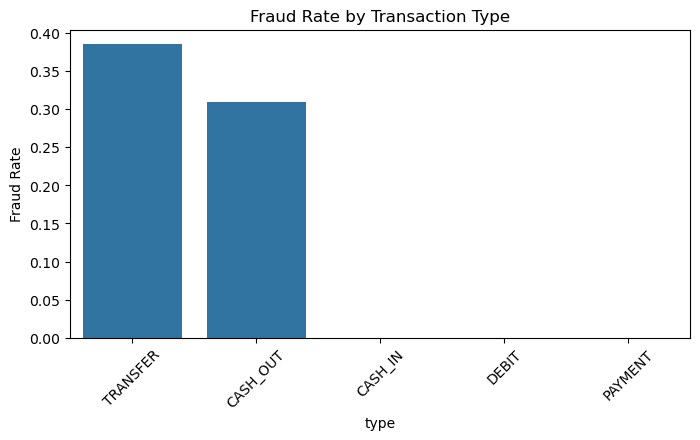

type
TRANSFER    0.385246
CASH_OUT    0.308926
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [28]:
# FRAUD RATE ACROSS TRANSACTION TYPES
fraud_rate = df_og.groupby('type')['isFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=fraud_rate.index, y=fraud_rate.values)
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()

fraud_rate


this visualization helps checking which payment type is mostly related to fraud and it clearly
shows TRANSFER AND CASH_OUT 

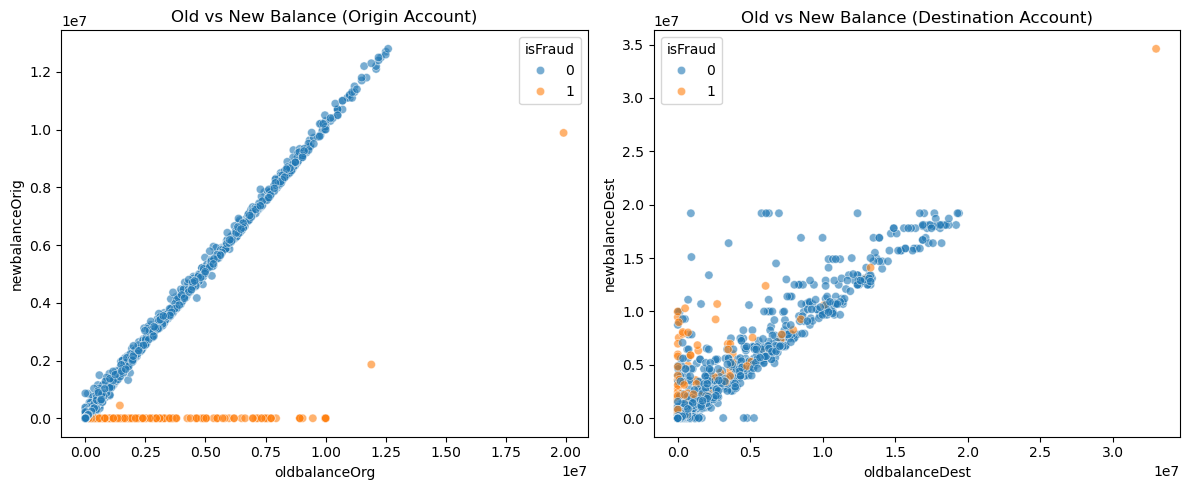

In [29]:
sample_df = df_og.sample(5000, random_state=42)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(data=sample_df, x='oldbalanceOrg', y='newbalanceOrig', hue='isFraud', alpha=0.6)
plt.title("Old vs New Balance (Origin Account)")

plt.subplot(1,2,2)
sns.scatterplot(data=sample_df, x='oldbalanceDest', y='newbalanceDest', hue='isFraud', alpha=0.6)
plt.title("Old vs New Balance (Destination Account)")

plt.tight_layout()
plt.show()


Scatter plots of old vs new balances highlight clear behavioral differences between legitimate and fraudulent transactions.
Normal transactions follow expected balance equations, forming clear linear trends. Fraudulent transactions break these patterns
-sender balances often drop to zero suddenly, and destination balances frequently do not update. These abnormal balance movements
are strong indicators of fraudulent activity.

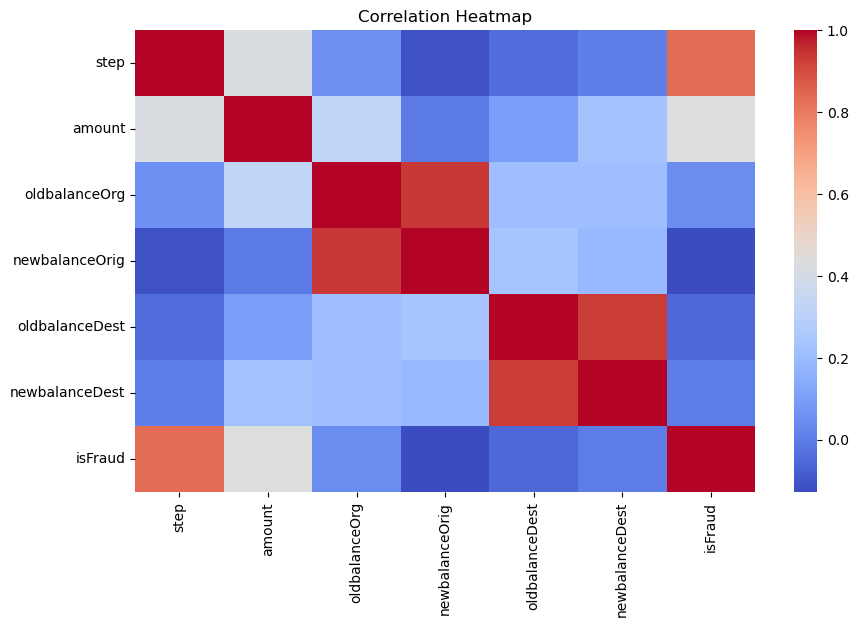

In [30]:
# CORRELATION HEATMAP
# Select only numeric columns for correlation
numeric_df = df_og.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Balanced related features shows strong positive relationships which shows normal transaction behaviour
Fraud cannot be detected with simple linear relationships as there is low correlation with inidvidual numeric features
Fraud patterns arise from complex interactions between transaction type, amount, and balance inconsistencies. 
This confirms the need for advanced machine learning models rather than simple rule-based detection.

In [31]:
df.describe()
df['isFraud'].value_counts()
df['isFraud'].value_counts(normalize=True)


isFraud
0    0.897505
1    0.102495
Name: proportion, dtype: float64

In [32]:
df.shape

(11142, 22)

# STEP 6: HANDLING CLASS IMBALANCE

SMOTE OVERSAMPLING

In [33]:
df.isFraud.value_counts()

isFraud
0    10000
1     1142
Name: count, dtype: int64

In [34]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [74]:
print(X.columns)
print(len(X.columns))


Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'merchant_sender', 'merchant_reciever',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'org_diff', 'dest_diff', 'org_no_change', 'dest_no_change',
       'amount_ratio', 'hour', 'day', 'is_transfer', 'is_cashout'],
      dtype='object')
21


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [36]:
sm = SMOTE(random_state = 2)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [37]:
X_train_smote.shape, y_train_smote.shape

((16002, 21), (16002,))

In [38]:
len(y_train_smote[y_train_smote==0]),len(y_train_smote[y_train_smote==1])

(8001, 8001)

# LOGISTIC REGRESSION

In [39]:
space_lr = {
    'C': hp.loguniform('C', np.log(0.001), np.log(10)),   
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet']),    
    'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'saga']),   
    'l1_ratio': hp.uniform('l1_ratio', 0, 1),  
    'max_iter': hp.choice('max_iter', [200, 300, 500, 700]),   
    'class_weight': hp.choice('class_weight', [None, 'balanced']),    
    'tol': hp.loguniform('tol', np.log(1e-6), np.log(1e-3)),  
    'fit_intercept': hp.choice('fit_intercept', [True, False])
}


In [40]:
space_lr

{'C': <hyperopt.pyll.base.Apply at 0x17af16c10>,
 'penalty': <hyperopt.pyll.base.Apply at 0x17af7a330>,
 'solver': <hyperopt.pyll.base.Apply at 0x17a00f150>,
 'l1_ratio': <hyperopt.pyll.base.Apply at 0x17a2feb70>,
 'max_iter': <hyperopt.pyll.base.Apply at 0x17af017e0>,
 'class_weight': <hyperopt.pyll.base.Apply at 0x17a04c260>,
 'tol': <hyperopt.pyll.base.Apply at 0x17af314f0>,
 'fit_intercept': <hyperopt.pyll.base.Apply at 0x17af720d0>}

In [41]:
def objective_lr(space_lr): 
    if space_lr['penalty'] == 'l1' and space_lr['solver'] not in ['liblinear', 'saga']:
        return 999999 
    if space_lr['penalty'] == 'elasticnet' and space_lr['solver'] != 'saga':
        return 999999
    model = LogisticRegression(
        C=space_lr['C'],
        penalty=space_lr['penalty'],
        solver=space_lr['solver'],
        l1_ratio=space_lr['l1_ratio'] if space_lr['penalty']=='elasticnet' else None,
        max_iter=space_lr['max_iter'],
        class_weight=space_lr['class_weight'],
        tol=space_lr['tol'],
        fit_intercept=space_lr['fit_intercept'],
        random_state=42,
        n_jobs=-1
    )
    accuracy = cross_val_score(model, X_train_smote, y_train_smote, cv = 5).mean()

 # We aim to maximize accuracy, therefore we return it as a negative value   
    return {'loss': -accuracy, 'status': STATUS_OK }


In [42]:
trials = Trials()
best = fmin(fn=objective_lr,
            space=space_lr,  # Changed from space_lr to space
            algo=tpe.suggest,
            max_evals=90,
            trials=trials)
best

  1%|          | 1/90 [00:00<00:31,  2.79trial/s, best loss: -0.944381892377382]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

  2%|▏        | 2/90 [00:06<05:25,  3.70s/trial, best loss: -0.9751287683536395]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  8%|▋        | 7/90 [00:12<02:08,  1.55s/trial, best loss: -0.9914386715089034]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

 10%|▉        | 9/90 [00:14<01:57,  1.45s/trial, best loss: -0.9914386715089034]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

 11%|▉       | 10/90 [00:16<02:02,  1.53s/trial, best loss: -0.9914386715089034]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 13%|█       | 12/90 [00:23<02:44,  2.11s/trial, best loss: -0.9914386715089034]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

 14%|█▏      | 13/90 [00:24<02:29,  1.94s/trial, best loss: -0.9914386715089034]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 16%|█▏      | 14/90 [00:29<03:38,  2.87s/trial, best loss: -0.9914386715089034]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

 17%|█▎      | 15/90 [00:30<02:55,  2.34s/trial, best loss: -0.9914386715089034]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 48%|███▊    | 43/90 [03:05<03:19,  4.24s/trial, best loss: -0.9935633591065292]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 51%|████    | 46/90 [03:20<04:01,  5.49s/trial, best loss: -0.9935633591065292]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

 52%|████▏   | 47/90 [03:22<03:15,  4.56s/trial, best loss: -0.9935633591065292]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 54%|████▎   | 49/90 [03:26<02:09,  3.17s/trial, best loss: -0.9935633591065292]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

 56%|████▍   | 50/90 [03:27<01:41,  2.55s/trial, best loss: -0.9935633591065292]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 94%|███████▌| 85/90 [05:20<00:09,  1.92s/trial, best loss: -0.9935633591065292]

Exception ignored in: <function ResourceTracker.__del__ at 0x108169800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes


100%|████████| 90/90 [05:34<00:00,  3.72s/trial, best loss: -0.9935633591065292]


{'C': np.float64(7.176088792438208),
 'class_weight': np.int64(0),
 'fit_intercept': np.int64(0),
 'l1_ratio': np.float64(0.80647481501105),
 'max_iter': np.int64(1),
 'penalty': np.int64(0),
 'solver': np.int64(0),
 'tol': np.float64(5.007442116473317e-06)}

In [43]:
cw  = {0:None, 1:'balanced', 3:None}  
fi  = {0:True, 1:False}
mi  = {0:200, 1:300, 2:500, 3:700}
pen = {0:'l1', 1:'l2', 2:'elasticnet'}  
sol = {0:'liblinear', 1:'lbfgs', 2:'saga'}  

# Convert numpy int64 to regular Python int for dictionary lookup
# This handles the np.int64(3) issue
best_class_weight = int(best['class_weight'])
best_fit_intercept = int(best['fit_intercept'])
best_max_iter = int(best['max_iter'])
best_penalty = int(best['penalty'])
best_solver = int(best['solver'])

print(cw[best_class_weight])
print(fi[best_fit_intercept])
print(mi[best_max_iter])
print(pen[best_penalty])
print(sol[best_solver])

None
True
300
l1
liblinear


In [44]:
model_lr = LogisticRegression(
    C = best['C'],
    penalty = pen[best['penalty']],
    solver = sol[best['solver']],
    l1_ratio = best['l1_ratio'] if pen[best['penalty']] == 'elasticnet' else None,
    max_iter = mi[best['max_iter']],
    class_weight = cw[best['class_weight']],
    tol = best['tol'],
    fit_intercept = fi[best['fit_intercept']],
    n_jobs = -1,
    random_state = 42
)
model_lr.fit(X_train_smote, y_train_smote)


LogisticRegression(C=np.float64(7.176088792438208), max_iter=300, n_jobs=-1,
                   penalty='l1', random_state=42, solver='liblinear',
                   tol=np.float64(5.007442116473317e-06))

In [45]:
y_pred = model_lr.predict(X_test)


In [46]:
print(f"accuracy_score:{accuracy_score(y_test,y_pred)}")
print(f"confusion_matrix \n :{confusion_matrix(y_test,y_pred)}")
print(f"classification_report \n :{classification_report(y_test,y_pred)}")

accuracy_score:0.9901301031852848
confusion_matrix 
 :[[1984   15]
 [   7  223]]
classification_report 
 :              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1999
           1       0.94      0.97      0.95       230

    accuracy                           0.99      2229
   macro avg       0.97      0.98      0.97      2229
weighted avg       0.99      0.99      0.99      2229



In [47]:
# OVERFITTING CHECK
print("Train Accuracy:", model_lr.score(X_train_smote, y_train_smote))
print("Test Accuracy:", model_lr.score(X_test, y_test))


Train Accuracy: 0.9935633045869267
Test Accuracy: 0.9901301031852848


# RANDOM FOREST

In [48]:
space = {
    'criterion': hp.choice('criterion', ['entropy', 'gini']),    
    'max_depth': hp.quniform("max_depth", 5, 40, 2),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),  # FIXED
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 1.0),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 500, 800])
}

In [49]:
space

{'criterion': <hyperopt.pyll.base.Apply at 0x17af83550>,
 'max_depth': <hyperopt.pyll.base.Apply at 0x17af836d0>,
 'max_features': <hyperopt.pyll.base.Apply at 0x17af83150>,
 'min_samples_leaf': <hyperopt.pyll.base.Apply at 0x17af82050>,
 'min_samples_split': <hyperopt.pyll.base.Apply at 0x17af81b50>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x17afce3d0>}

In [50]:
def objective(space):

    model = RandomForestClassifier(
        criterion = space['criterion'],
        max_depth = int(space['max_depth']),
        max_features = space['max_features'],     
        min_samples_leaf = space['min_samples_leaf'],
        min_samples_split = space['min_samples_split'],
        n_estimators = space['n_estimators'],
        random_state=42
    )

    acc = cross_val_score(model, X_train_smote, y_train_smote, cv=5).mean()
    return {'loss': -acc, 'status': STATUS_OK}

In [51]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 50,
            trials= trials)
best

 56%|█████    | 28/50 [02:09<02:44,  7.49s/trial, best loss: -0.984814647766323]

Exception ignored in: <function ResourceTracker.__del__ at 0x1039e1800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes


 58%|█████▏   | 29/50 [02:44<05:34, 15.95s/trial, best loss: -0.984814647766323]

Exception ignored in: <function ResourceTracker.__del__ at 0x108a91800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106f35800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes


 60%|█████▍   | 30/50 [02:48<04:08, 12.41s/trial, best loss: -0.984814647766323]

Exception ignored in: <function ResourceTracker.__del__ at 0x110889800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10514d800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105381800>
Traceback (most recent call last

100%|████████| 50/50 [05:02<00:00,  6.05s/trial, best loss: -0.9854395891908778]


{'criterion': np.int64(1),
 'max_depth': np.float64(10.0),
 'max_features': np.int64(1),
 'min_samples_leaf': np.float64(0.03616518268356754),
 'min_samples_split': np.float64(0.026297493266018115),
 'n_estimators': np.int64(4)}

In [52]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'sqrt', 1: 'log2', 2: None}
est  = {0: 100, 1: 200, 2: 300, 3: 500, 4: 800}

print("criterion:", crit[best['criterion']])
print("max_features:", feat[best['max_features']])
print("n_estimators:", est[best['n_estimators']])

criterion: gini
max_features: log2
n_estimators: 800


In [53]:
model_rf = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = int(best['max_depth']), 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']])
model_rf.fit(X_train_smote,y_train_smote)

RandomForestClassifier(max_depth=10, max_features='log2',
                       min_samples_leaf=np.float64(0.03616518268356754),
                       min_samples_split=np.float64(0.026297493266018115),
                       n_estimators=800)

In [54]:
y_pred=model_rf.predict(X_test)

In [55]:
print(f"accuracy_score:{accuracy_score(y_test,y_pred)}")
print(f"confusion_matrix \n :{confusion_matrix(y_test,y_pred)}")
print(f"classification_report \n :{classification_report(y_test,y_pred)}")

accuracy_score:0.9932705248990579
confusion_matrix 
 :[[1999    0]
 [  15  215]]
classification_report 
 :              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1999
           1       1.00      0.93      0.97       230

    accuracy                           0.99      2229
   macro avg       1.00      0.97      0.98      2229
weighted avg       0.99      0.99      0.99      2229



In [56]:
# OVERFITTING CHECK
print("Train Accuracy:", model_rf.score(X_train_smote, y_train_smote))
print("Test Accuracy:", model_rf.score(X_test, y_test))


Train Accuracy: 0.9864391951006124
Test Accuracy: 0.9932705248990579


 # XGBOOST 

In [57]:
space_xgb = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'subsample': hp.uniform('subsample', 0.2, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0),
    'min_child_weight': hp.uniform('min_child_weight', 1, 20),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 500, 800]),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.0001), np.log(10)),


}

In [58]:
def objective_xgb(space_xgb):

    model = XGBClassifier(
        learning_rate = space_xgb['learning_rate'],
        max_depth = int(space_xgb['max_depth']),
        gamma = space_xgb['gamma'],
        subsample = space_xgb['subsample'],
        colsample_bytree = space_xgb['colsample_bytree'],
        min_child_weight = space_xgb['min_child_weight'],
        n_estimators =space_xgb['n_estimators'],
        reg_alpha = space_xgb['reg_alpha'],
        reg_lambda = space_xgb['reg_lambda'],
        random_state = 42,
        n_jobs = -1,
        tree_method = 'hist'  # much faster
    )
    acc = cross_val_score(model, X_train_smote, y_train_smote, cv=5).mean()
    return {'loss': -acc, 'status': STATUS_OK}

In [59]:
trials = Trials()
best = fmin(fn= objective_xgb,
            space= space_xgb,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|████████| 80/80 [00:52<00:00,  1.54trial/s, best loss: -0.9998125585754452]


{'colsample_bytree': np.float64(0.26425566294577535),
 'gamma': np.float64(0.26561361432089925),
 'learning_rate': np.float64(0.1948693372940224),
 'max_depth': np.float64(6.0),
 'min_child_weight': np.float64(4.308917606970031),
 'n_estimators': np.int64(3),
 'reg_alpha': np.float64(0.0051963885793576),
 'reg_lambda': np.float64(0.19772980758556793),
 'subsample': np.float64(0.9580919218917342)}

In [60]:
est = {0:100, 1:200, 2:300, 3:500, 4:800}
print("n_estimators:", est[best['n_estimators']])

n_estimators: 500


In [61]:
model_xgb = XGBClassifier(
                colsample_bytree = best['colsample_bytree'],
                gamma = best['gamma'],
                learning_rate = best['learning_rate'],
                max_depth = int(best['max_depth']),
                min_child_weight = best['min_child_weight'],
                n_estimators = est[best['n_estimators']],  
                subsample = best['subsample'],
                reg_alpha = best['reg_alpha'],
                reg_lambda = best['reg_lambda'],
                random_state = 42,
                n_jobs = -1,
                tree_method = 'hist'
)

model_xgb.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.26425566294577535), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=np.float64(0.26561361432089925), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.1948693372940224), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=np.float64(4.308917606970031), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [62]:
y_pred = model_xgb.predict(X_test)

In [63]:
print(f"accuracy_score:{accuracy_score(y_test,y_pred)}")
print(f"confusion_matrix \n :{confusion_matrix(y_test,y_pred)}")
print(f"classification_report \n :{classification_report(y_test,y_pred)}")

accuracy_score:1.0
confusion_matrix 
 :[[1999    0]
 [   0  230]]
classification_report 
 :              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1999
           1       1.00      1.00      1.00       230

    accuracy                           1.00      2229
   macro avg       1.00      1.00      1.00      2229
weighted avg       1.00      1.00      1.00      2229



In [64]:
#OVERFITTING CHECK
print("Train Accuracy:", model_xgb.score(X_train_smote, y_train_smote))
print("Test Accuracy:", model_xgb.score(X_test, y_test))


Train Accuracy: 0.9999375078115236
Test Accuracy: 1.0


# MODEL COMPARISON

STEP1: Put all models in a list

In [65]:
models = [
      ("Logistic", model_lr),
      ("RandomForest", model_rf),
      ("XGBoost", model_xgb)
]


STEP2: Comparing all models:

In [66]:
comparison = []

for name , model in models:
    y_pred= model.predict(X_test)

    comparison.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

df_results = pd.DataFrame(comparison)
df_results
    

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic,0.990130,0.936975,0.969565,0.952991
1,RandomForest,0.993271,1.000000,0.934783,0.966292
2,XGBoost,1.000000,1.000000,1.000000,1.000000


STEP3: Finding the best model:

In [67]:
df_results["WeightedScore"] =(
      0.5 * df_results["Precision"] +
      0.3 * df_results["Recall"] +
      0.2 * df_results["F1-Score"]
)

In [68]:
best_model = df_results.sort_values(["WeightedScore"],ascending=False).iloc[0]["Model"]
best_model

'XGBoost'

PLOTTING ROC AUC COMPARISON CURVE

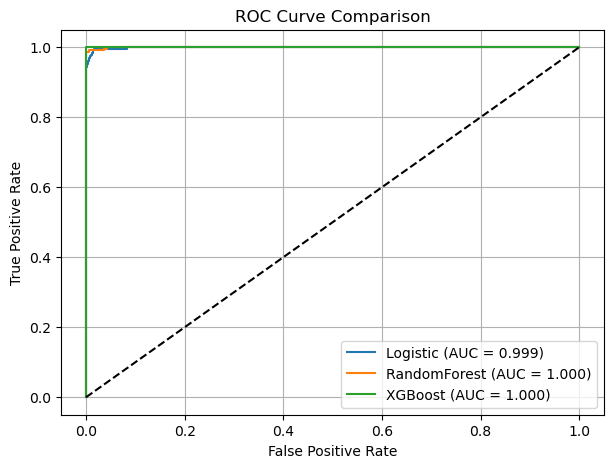

In [69]:
plt.figure(figsize=(7,5))

for name, model in models:
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        continue 
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")  # Added closing parenthesis here
             
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# MODEL DEPLOYMENT

SAVING THE TRAINED MODEL

In [70]:
filename = 'Xgb_pred_model.pkl'
pickle.dump(model_xgb, open(filename,'wb'))

LOADING THE TRAINED MODEL

In [71]:
model_load = pickle.load(open('Xgb_pred_model.sav','rb'))

CHECKING THE TRAINED MODEL

In [72]:
input_data = (1,181.00,181.00,0.00,0.00,0.00,0,0,False,False,False,True,181.00,0.00,0,1,0.994505,1,0,False,False)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = model_load.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('The transaction is notfraud')
else:
  print('The transaction is fraud')

[1]
The transaction is fraud


# GITHUB REPOSITORY

https://github.com/AngshuSingha/Fraud-Detection

# Business Questions to Address: 

1)What is the model's precision and accuracy in detecting fraudulent transactions?
- The XgBoost model achieved perfect classification on the dataset
  It delivered accuracy, precision, recall, f1-score of 1.0 (no errors)
  This performance reflects exceptionally strong predictive capability.

2)How reliable is the model in classifying transactions as legitimate or fraudulent? 
- The model is highly reliable in correctly classifying all transactions with zero misclassification, 
  indicating consistent and dependable fraud detection.

3)What are the potential losses due to model errors? 
- Since the model recorded 0-false negative, 0-false positives,the system incurs no estimated monetary loss
  from misclassification of this dataset
  If the model produced False Negative fraudulent transaction would go unnoticed causing direct monetary loss to the company
  if the model produced False postive genuine transaction could be flagged causing organisational investigation cost
   leading to customer friction.